In [1]:
# load modules
#--------------------------------------------------------------
import numpy as np
import pandas as pd
import sys, os, time
import datetime
import re
from scipy.stats import norm
import matplotlib.pyplot as plt
import ray
sys.path.append('../..')

# import helpers
from src.utils import interp, get_xs, Params, get_xtv
from src.plots import scatter_plot, line_plot


from src.models.chain_gaussian import Chain_Gaussian
from src.mcmc_diagnostics.diagnostic import MCMCDiagnostic
from src.utils.serialize import pickle_obj, unpickle_obj, load_json, save_json
from src.utils.params import hash_dict

import torch
import hamiltorch

# import sampler classes
from src.sampling_algorithms import MaskedLocalBPS, LocalBPS
from src.sampling_algorithms.masked_bps.masked_bps_output import OutputReader
# plot settings
from matplotlib import rc
rc('text', usetex=False)

import arviz as az
from arviz.stats import ess


In [2]:
parent_dir = '../..'
os.environ["PYTHONPATH"] = parent_dir + ":" + os.environ.get("PYTHONPATH", "")


params_list = [Params({
    "refresh_rate": refresh_rate,
    "overlap": overlap,
    "num_factors": num_factors,
    "factor_dim": factor_dim,
    "mu": 0.,
    "prec":1.,
    "rho": rho,
    'run_time': run_time,
    'num_workers': 30
})
               for refresh_rate in [0.01, 0.01, 0.001]
               for rho in [0.25, 0.5, 0.75]
               for run_time in [60, 90, 600, 900]
               for overlap, factor_dim in [(1,100)]
               for num_factors in [10, 25, 50, 100, 150]
              ]
    

output_dir = "./"

In [3]:

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [ ]:
ray.shutdown()
ray_details = ray.init(memory=5*10**10, object_store_memory = 9*10**10)

## Masked BPS

In [5]:
# run masked bps
model_output_dir = os.path.join(output_dir, "masked_bps")


if not os.path.exists(model_output_dir):
        os.mkdir(model_output_dir)
    
for param_index in range(len(params_list)):
    params = params_list[param_index]
    param_hash = hash_dict(params.param_dict())
    
    ## set up output dir
    dir_name = "experiment_{0}".format(param_hash)
    dir_path = os.path.join(model_output_dir, dir_name)
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    
        # serialize params
        param_filepath = os.path.join(dir_path, "params.json")
        params.save_to_file(param_filepath)

        ## Define model
        model = Chain_Gaussian(params)
        
        # masked sampler
        #-----------------------------------------------------------------------------
        num_cuts = np.min([params.num_factors, params.num_workers-1])
        sample_mask_fn = lambda: model.sample_mask(num_cuts)
        init_mask = sample_mask_fn()
        
        # Shutdown and init ray
        if ray.is_initialized():
            ray.shutdown()

        ray.init(memory=5*10**10, object_store_memory = 9*10**10)
        

        # init values
        init_x = np.array([np.random.rand() for _ in range(model.num_params)])
        init_v = np.array([np.random.rand() for _ in range(model.num_params)])

        # init sampler
        #--------------------------------------------------------------------------------------
        mlbps = MaskedLocalBPS(init_x = init_x,
                               init_v = init_v,
                               init_mask = init_mask,
                               factor_graph=model,
                               bounce_fns=model.bounce_fns,
                               refresh_rate=model.params.refresh_rate,
                               split_mask_fn = model.split_mask_into_groups,
                               sample_mask_fn=sample_mask_fn,
                               max_number_sub_samplers = params.num_workers)

        # run sampler
        print('Masked Local BPS')
        print(params)
        start = datetime.datetime.now()
        print(start)
        res = mlbps.simulate_for_time(params.run_time, output_dir=dir_path)
        results, groups, masks = res
        stop = datetime.datetime.now()
        print(stop)
        time_delta = (stop-start).seconds
        print("Duration: {0}s".format(time_delta))
        
        output_file = os.path.join(dir_path, "time_delta.pickle")
        pickle_obj(time_delta, output_file)

# Shutdown and init ray
if ray.is_initialized():
    ray.shutdown()

In [6]:
res_cols = ['num_factors', 'iter_speed', 'ess_speed', 'sampler']
agg_res = []


In [ ]:
##### check masked bps
model_output_dir = os.path.join(output_dir, "masked_bps")

    
for param_index in range(len(params_list)):
    params = params_list[param_index]
    param_hash = hash_dict(params.param_dict())

    
    ## set up output dir
    dir_name = "experiment_{0}".format(param_hash)
    dir_path = os.path.join(model_output_dir, dir_name)
    if os.path.exists(dir_path):
        print(params)
                ## Define model
        model = Chain_Gaussian(params)
        
        # masked sampler
        #-----------------------------------------------------------------------------
        num_cuts = np.min([params.num_factors, params.num_workers])
        sample_mask_fn = lambda: model.sample_mask(num_cuts)
        init_mask = sample_mask_fn()
        
        # Shutdown and init ray
        if ray.is_initialized():
            ray.shutdown()

        ray.init(memory=5*10**10, object_store_memory = 9*10**10)
        

        # init values
        init_x = np.array([np.random.rand() for _ in range(model.num_params)])
        init_v = np.array([np.random.rand() for _ in range(model.num_params)])

        # init sampler
        #--------------------------------------------------------------------------------------
        mlbps = MaskedLocalBPS(init_x = init_x,
                               init_v = init_v,
                               init_mask = init_mask,
                               factor_graph=model,
                               bounce_fns=model.bounce_fns,
                               refresh_rate=model.params.refresh_rate,
                               split_mask_fn = model.split_mask_into_groups,
                               sample_mask_fn=sample_mask_fn,
                               max_number_sub_samplers = params.num_workers)
        
        output_reader = OutputReader(mlbps)
        output_file = os.path.join(dir_path, "time_delta.pickle")
        time_delta = unpickle_obj(output_file)
        output, num_iterations = output_reader.read_output(dir_path, verbose = False, inplace =False)
        
        d = min(50,mlbps.d)
        chains = {}
        for i in range(d):
            x, v, t, mask = output[i]['x'], output[i]['v'], output[i]['t'], output[i]['mask']
            x = np.array(x)
            v = np.array(v)
            t = np.array(t)
            mask = np.array(mask)
            nsim = len(x)
            xs = interp(x, t, v*mask, num_intervals= nsim*12)
            chains["x_{0}".format(i)] = xs
        mcmc_diagnostic_obj = MCMCDiagnostic(chains)
        esses = [mcmc_diagnostic_obj.ess('x_{0}'.format(i)) for i in range(d)]
        
        iteration_speed = num_iterations/time_delta
        ess_speed  = np.mean(esses)/time_delta
        agg_res.append([params.num_factors, iteration_speed, ess_speed, 'masked_bps'])
        print(params)
        print("ESS /S: {0}".format(ess_speed))
        print("Iterations /S: {0}".format(iteration_speed))
        print("\n")

## HMC

In [14]:
ess_plot = res_df \
.loc[:,['num_factors', 'sampler', 'ess_speed']] \
.set_index(['sampler', 'num_factors'])\
.unstack(0)

ess_plot.T

num_factors                 10         25         50        100       150
          sampler                                                        
ess_speed hmc          0.778217   0.312917   0.160617  0.077136  0.053159
          local_bps   31.150533  11.795421   6.446921  2.874147  1.416014
          masked_bps  48.204466  40.619832  22.652604  8.164055  5.971584

In [8]:
num_samples = 10000
step_size = .3
num_steps_per_sample = 5

In [9]:
# run hmc 
model_output_dir = os.path.join(output_dir, "hmc")

if not os.path.exists(model_output_dir):
        os.mkdir(model_output_dir)
        
for param_index in range(len(params_list)):
    params = params_list[param_index]#param_index
    param_hash = hash_dict(params.param_dict())
    
    ## set up output dir
    dir_name = "experiment_{0}".format(param_hash)
    dir_path = os.path.join(model_output_dir, dir_name)
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    
        # serialize params
        param_filepath = os.path.join(dir_path, "params.json")
        params.save_to_file(param_filepath)
    
        # define model
        factor_dim = params.factor_dim
        overlap = params.overlap
        num_factors = params.num_factors

        chain_length = factor_dim + (factor_dim - overlap) * (num_factors - 1)
        mus = np.repeat(params.mu, chain_length)
        prec = np.repeat(params.prec, chain_length)
        rho = np.repeat(params.rho, chain_length - 1)
        factor_indices = np.array([np.array([i + j for j in range(factor_dim)])
                                           for i in range(0, (factor_dim - overlap) * num_factors, factor_dim - overlap)])
        ind = factor_indices[0]
        Precs = [[prec[i] * prec[j] for j in ind] for i in ind]
        rhos = [[1 if i == j else rho[i] if j == i + 1 else rho[j] if i == j + 1 else 0 for j in ind] 
                for i in ind]
        Prec = np.array(rhos) * np.array(Precs)
        Sig = np.linalg.pinv(Prec)
        mu = mus[ind]
        Prec = np.array(rhos) * np.array(Precs)
        Sig0 = np.linalg.pinv(Prec)
        mu0 = mus[ind]
        mu0 = torch.tensor(mu0)
        Sig0 = torch.tensor(Sig0)  

        params_cache = []
        for ind in factor_indices[1:]:
                # extract params
                Precs = [[prec[i] * prec[j] for j in ind] for i in ind]
                rhos = [[1 if i == j else rho[i] if j == i + 1 else rho[j] if i == j + 1 else 0 for j in ind] for i in ind]
                Prec = np.array(rhos) * np.array(Precs)
                mu = mus[ind]
                num_steps = factor_dim - overlap
                Sig = np.linalg.pinv(Prec)

                mu2 = mu[:-num_steps]
                mu1 = mu[-num_steps:]
                Sig2 = Sig[:-num_steps, :-num_steps]
                Sig1 = Sig[-num_steps:, -num_steps:]
                Sig21 = Sig[:-num_steps, -num_steps:]
                Sig12 = Sig21.T
                inv_sig2 = np.linalg.inv(Sig2)
                transform = Sig12.dot(inv_sig2)
                sig_bar = Sig1 - transform.dot(Sig21)
                transform = torch.tensor(transform)
                mu1 = torch.tensor(mu1)
                mu2 = torch.tensor(mu2)
                Sig = torch.tensor(sig_bar)  
                params_cache.append((mu1, mu2, Sig, transform))

        def log_prob_x0(x, mu, Sig):
            mu = torch.tensor(mu)
            Sig = torch.tensor(Sig)  
            return torch.distributions.MultivariateNormal(loc = mu, covariance_matrix = Sig).log_prob(x).sum()

        def conditional_func(x1, x2, mu1, mu2, sig_bar, transform):
            mu_bar = mu1 + torch.mv(transform, (x2 - mu2))
            return torch.distributions.MultivariateNormal(loc = mu_bar, covariance_matrix = Sig).log_prob(x1).sum()

        def log_prob_func(x):
            total = log_prob_x0(x[factor_indices[0]], mu0, Sig0)

            for i in range(len(factor_indices[1:])):
                ind = factor_indices[1:][i]
                # tensors
                x_ind = x[ind]
                x1 = x_ind[1:] #.unsqueeze(0)
                x2 = x_ind[0]  #.unsqueeze(0)
                total += conditional_func(x1, x2, mu1, mu2, sig_bar, transform)
            return total

        params_init = torch.tensor(np.random.random(chain_length))

        print('HMC')
        start = datetime.datetime.now()
        print(start)
        params_hmc = hamiltorch.sample(log_prob_func=log_prob_func, 
                                       params_init=params_init,  
                                       num_samples=num_samples, 
                                       step_size=step_size, 
                                       num_steps_per_sample=num_steps_per_sample)
        stop = datetime.datetime.now()
        time_delta = (stop-start).seconds
        numpy_chains = np.swapaxes(torch.stack(params_hmc).numpy(), 0,1)

        output_file = os.path.join(dir_path, "chains.pickle")
        pickle_obj(numpy_chains, output_file)

        output_file = os.path.join(dir_path, "time_delta.pickle")
        pickle_obj(time_delta, output_file)

In [ ]:
#check hmc
model_output_dir = os.path.join(output_dir, "hmc")

    
for param_index in range(len(params_list)):
    params = params_list[param_index]
    param_hash = hash_dict(params.param_dict())

    
    ## set up output dir
    dir_name = "experiment_{0}".format(param_hash)
    dir_path = os.path.join(model_output_dir, dir_name)
    if os.path.exists(dir_path):
        print(params)
        output_file = os.path.join(dir_path, "chains.pickle")
        numpy_chains = unpickle_obj(output_file)

        output_file = os.path.join(dir_path, "time_delta.pickle")
        time_delta = unpickle_obj(output_file)
    
        chains = {}
        d = min(50,np.shape(numpy_chains)[0])
        for i in range(d):
            chains['x_{0}'.format(i)] = numpy_chains[i]

        mcmc_diagnostic_obj = MCMCDiagnostic(chains)
        esses = [mcmc_diagnostic_obj.ess('x_{0}'.format(i)) for i in range(d)]
        
        iteration_speed = np.shape(numpy_chains)[1]/time_delta
        ess_speed  = np.mean(esses)/time_delta
        agg_res.append([params.num_factors, iteration_speed, ess_speed, 'hmc'])
        
        print(params)
        print("ESS /S: {0}".format(ess_speed))
        print("Iterations /S: {0}".format(iteration_speed))
        print("\n")

## Local BPS

In [11]:
# run local bps
model_output_dir = os.path.join(output_dir, "local_bps")


if not os.path.exists(model_output_dir):
        os.mkdir(model_output_dir)
    
for param_index in range(len(params_list)):
    params = params_list[param_index]
    param_hash = hash_dict(params.param_dict())
    
    ## set up output dir
    dir_name = "experiment_{0}".format(param_hash)
    dir_path = os.path.join(model_output_dir, dir_name)
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    
        # serialize params
        param_filepath = os.path.join(dir_path, "params.json")
        params.save_to_file(param_filepath)

        ## Define model
        model = Chain_Gaussian(params)
        
        
        # init values
        init_x = np.array([np.random.rand() for _ in range(model.num_params)])
        init_v = np.array([np.random.rand() for _ in range(model.num_params)])

        # init sampler
        #--------------------------------------------------------------------------------------
        local_bps = LocalBPS(init_x = init_x,
                               init_v = init_v,
                               factor_graph=model,
                               bounce_fns=model.bounce_fns,
                               refresh_rate=model.params.refresh_rate)

        # run sampler
        print('Local BPS')
        start = datetime.datetime.now()
        print(start)
        res = local_bps.simulate_for_time(params.run_time)
        stop = datetime.datetime.now()
        print(stop)
        time_delta = (stop-start).seconds
        print("Duration: {0}s".format(time_delta))
        
        output_file = os.path.join(dir_path, "chains.pickle")
        pickle_obj(res, output_file)
        
        output_file = os.path.join(dir_path, "time_delta.pickle")
        pickle_obj(time_delta, output_file)



In [ ]:
#check local bps
model_output_dir = os.path.join(output_dir, "local_bps")

    
for param_index in range(len(params_list)):
    params = params_list[param_index]
    param_hash = hash_dict(params.param_dict())

    
    ## set up output dir
    dir_name = "experiment_{0}".format(param_hash)
    dir_path = os.path.join(model_output_dir, dir_name)
    if os.path.exists(dir_path):
        print(params)
        output_file = os.path.join(dir_path, "chains.pickle")
        res = unpickle_obj(output_file)

        output_file = os.path.join(dir_path, "time_delta.pickle")
        time_delta = unpickle_obj(output_file)

        chains = {}
        
        d = min(50,np.shape(res)[2])
        for i in range(d):
            x1,v1,t1=get_xtv(res,i)
            nsim = len(x1)
            x = interp(x1,t1,v1, num_intervals=nsim*12)
            chains["x_{0}".format(i)] = x

        mcmc_diagnostic_obj = MCMCDiagnostic(chains)
        esses = [mcmc_diagnostic_obj.ess('x_{0}'.format(i)) for i in range(d)]
        
        ess_speed = np.mean(esses)/time_delta
        iteration_speed = np.shape(res)[0]/time_delta
        
        agg_res.append([params.num_factors, iteration_speed, ess_speed, 'local_bps'])
        print(params)
        print("ESS /S: {0}".format(ess_speed))
        print("Iterations /S: {0}".format(iteration_speed))
        print("\n")

In [13]:
res_df = pd.DataFrame(agg_res, columns = res_cols)

In [15]:
import seaborn as sns

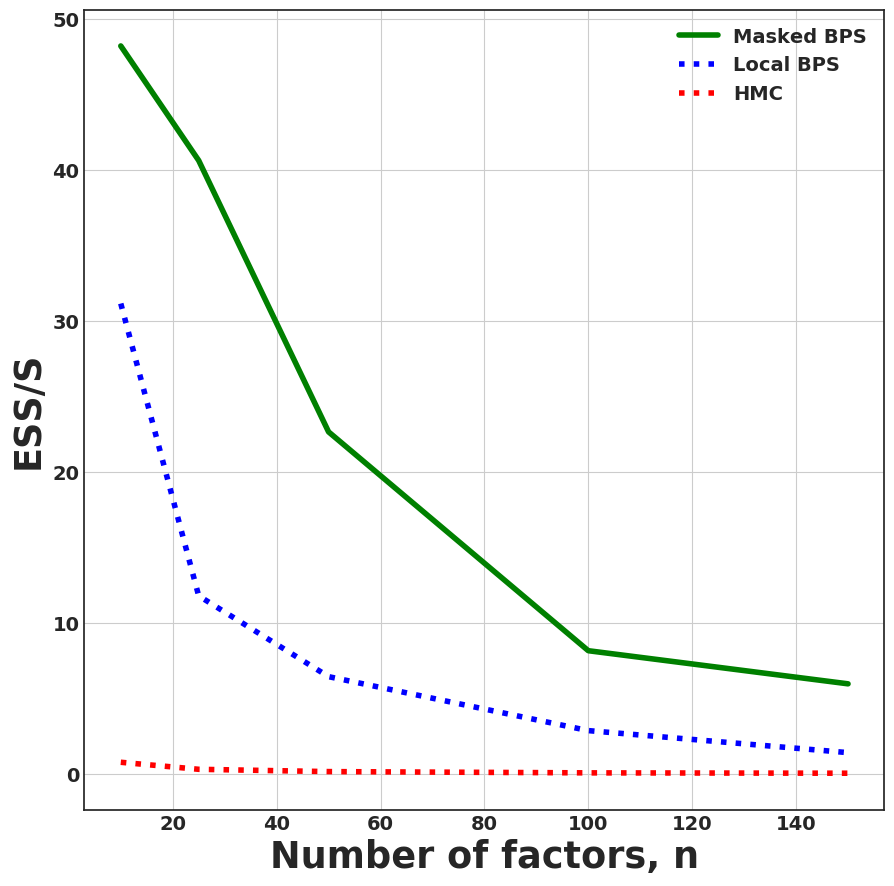

In [16]:
sns.set_style("whitegrid")
plot_limit = 1000
fig_size = (10,10)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams['lines.linewidth'] = 4

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=fig_size,frameon =True)
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

ax.set_title("", fontsize='large', fontweight='bold')
ax.set_xlabel("Number of factors, n",fontsize='large', fontweight='bold')
ax.set_ylabel("ESS/S",fontsize='large', fontweight='bold')

x = ess_plot.index.values

y1 = res_df.loc[res_df.sampler == 'masked_bps', 'ess_speed']
y2 = res_df.loc[res_df.sampler == 'local_bps', 'ess_speed']
y3 = res_df.loc[res_df.sampler == 'hmc', 'ess_speed']

plt.plot(x, y1, '-g', label='Masked BPS')
plt.plot(x, y2, ':b', label='Local BPS')
plt.plot(x, y3, ':r', label='HMC')

plt.legend();

fig.savefig('./ess_plot.eps', format='eps', dpi=1200)